## Trip Lab notebook PREV V4
Prepare dataset with numberic values, boolean values, duration features from dates, and now... date attributes.

Based on what is known before the driver starts driving, predict when the driver will arrive at the pick up location relative to the expected start time. What factors are most predictive of lateness?

In [1]:
import pandas as pd
import numpy as np

In [2]:
dateColNames=['canceled_at_pdt', 'claimed_at_pdt', 'departs_for_trip_at_pdt',
       'created_at_pdt', 'scheduled_starts_at_pdt', 'scheduled_ends_at_pdt',
       'origin_arrived_at_pdt', 'origin_departed_at_pdt',
       'destination_arrived_at_pdt', 'lead_organizer_created_at_pdt',
       'driver_created_at_pdt']

In [3]:
df=pd.read_csv('/Users/bob 2/Projects/TripsData2017.txt', sep='\t', parse_dates=dateColNames)

In [4]:
df.shape

(217348, 74)

In [5]:
list(df)

['id',
 'trip_state',
 'canceled_by',
 'canceled_at_pdt',
 'canceled_before_scheduled_start',
 'claimed_at_pdt',
 'driver_id',
 'lead_organizer_id',
 'creator_id',
 'carpool',
 'is_repeating_ride',
 'shuttle',
 'trip_template_id',
 'departs_for_trip_at_pdt',
 'time_anchor',
 'created_at_pdt',
 'scheduled_starts_at_pdt',
 'scheduled_ends_at_pdt',
 'origin_arrived_at_pdt',
 'origin_departed_at_pdt',
 'destination_arrived_at_pdt',
 'origin_location_id',
 'destination_location_id',
 'origin_region_id',
 'origin_analysis_metro_name',
 'destination_region_id',
 'destination_region_name',
 'origin_region_name',
 'origin_metro_area_name',
 'destination_metro_area_name',
 'destination_analysis_metro_name',
 'origin_lat',
 'origin_lon',
 'destination_lat',
 'destination_lon',
 'passengers_ids',
 'organizers_count',
 'passengers_count',
 'driver_home_lat',
 'driver_home_lon',
 'organizer_home_lat',
 'organizer_home_lon',
 'rating',
 'canceled_by_id',
 'route_legs_count',
 'start_waypoints_zipcode

In [6]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217348 entries, 0 to 217347
Columns: 74 entries, id to driver_has_driven_this_route_before
dtypes: bool(8), datetime64[ns](11), float64(29), int64(5), object(21)
memory usage: 111.1+ MB


In [7]:
df.info

<bound method DataFrame.info of             id trip_state canceled_by     canceled_at_pdt  \
0       367322   canceled    Employee 2017-03-08 13:18:55   
1       492666   canceled    Employee 2017-09-11 09:09:43   
2       527985   canceled    Employee 2017-09-27 14:02:52   
3       415557   canceled    Employee 2017-05-22 13:47:32   
4       317210   canceled    Employee 2017-01-18 10:14:22   
5       338150   complete         NaN                 NaT   
6       310958   complete         NaN                 NaT   
7       338135   complete         NaN                 NaT   
8       324615   complete         NaN                 NaT   
9       247127   complete         NaN                 NaT   
10      306833   complete         NaN                 NaT   
11      436184   complete         NaN                 NaT   
12      473473   complete         NaN                 NaT   
13      354050   complete         NaN                 NaT   
14      415507   complete         NaN                

#### columns_from_the_future must not be used in predictions but some are needed to label the data

In [8]:
columns_from_the_future = ['trip_state', 'canceled_by', 'canceled_at_pdt', 'canceled_before_scheduled_start', 'departs_for_trip_at_pdt', 'origin_arrived_at_pdt', 'origin_departed_at_pdt', 'destination_arrived_at_pdt', 'rating', 'trip_paid_time', 'driver_fare_multiplier', 'events', 'has_cd_unclaimed_event', 'is_unfilled_canceled', 'is_cd_cancel', 'canceled_by_id', 'commute_distance', 'predicted_driver_fare_with_multiplier']
print(columns_from_the_future)
print(len(columns_from_the_future))

['trip_state', 'canceled_by', 'canceled_at_pdt', 'canceled_before_scheduled_start', 'departs_for_trip_at_pdt', 'origin_arrived_at_pdt', 'origin_departed_at_pdt', 'destination_arrived_at_pdt', 'rating', 'trip_paid_time', 'driver_fare_multiplier', 'events', 'has_cd_unclaimed_event', 'is_unfilled_canceled', 'is_cd_cancel', 'canceled_by_id', 'commute_distance', 'predicted_driver_fare_with_multiplier']
18


In [9]:
list(df.select_dtypes(['object']).columns)

['trip_state',
 'canceled_by',
 'time_anchor',
 'origin_analysis_metro_name',
 'destination_region_name',
 'origin_region_name',
 'origin_metro_area_name',
 'destination_metro_area_name',
 'destination_analysis_metro_name',
 'passengers_ids',
 'rating',
 'start_waypoints_zipcodes',
 'end_waypoints_zipcodes',
 'lead_organizer_platform',
 'lead_organizer_app_version',
 'driver_platform',
 'driver_app_version',
 'driver_gender',
 'coupon',
 'events',
 'has_cd_unclaimed_event']

In [10]:
df.dtypes

id                                                  int64
trip_state                                         object
canceled_by                                        object
canceled_at_pdt                            datetime64[ns]
canceled_before_scheduled_start                   float64
claimed_at_pdt                             datetime64[ns]
driver_id                                         float64
lead_organizer_id                                   int64
creator_id                                          int64
carpool                                              bool
is_repeating_ride                                    bool
shuttle                                              bool
trip_template_id                                  float64
departs_for_trip_at_pdt                    datetime64[ns]
time_anchor                                        object
created_at_pdt                             datetime64[ns]
scheduled_starts_at_pdt                    datetime64[ns]
scheduled_ends

#### pick features to use as input to prediction. here just numerics, booleans, durations, date attributes and not those from the future.
todo: object features as categorical dummies, saturate outliers in data set

In [11]:
# compute duration features
durationTuples=[('claimed_before_trip_start_secs', 'claimed_at_pdt', 'scheduled_starts_at_pdt'), 
                ('trip_created_before_trip_start_secs', 'created_at_pdt', 'scheduled_starts_at_pdt'),
                ('trip_est_duration_secs', 'scheduled_starts_at_pdt', 'scheduled_ends_at_pdt'),
                ('org_signup_before_trip_start_secs', 'lead_organizer_created_at_pdt', 'scheduled_starts_at_pdt'),
                ('driver_signup_before_trip_start_secs', 'driver_created_at_pdt', 'scheduled_starts_at_pdt'),
                ('trip_claimed_after_trip_created', 'claimed_at_pdt', 'created_at_pdt'),
                ('driver_signup_before_trip_claimed_secs', 'driver_created_at_pdt', 'claimed_at_pdt'),
                ('org_signup_before_trip_created_secs', 'lead_organizer_created_at_pdt', 'created_at_pdt'),
                ('driver_signup_before_trip_created_secs', 'driver_created_at_pdt', 'created_at_pdt'),
                ('driver_signup_before_org_signup_secs', 'driver_created_at_pdt', 'lead_organizer_created_at_pdt')
                ]

#duration_col_name, from_time, to_time = durationTuples[1]
#print (duration_col_name, from_time, to_time)
#print (df.iloc[0][[from_time, to_time]])
#print((df.iloc[0][to_time] - df.iloc[0][from_time]).total_seconds())
#df[duration_col_name] = (df[to_time] - df[from_time]).dt.total_seconds()
#df[duration_col_name].head()

for duration_col_name, from_time, to_time in durationTuples:
    print("creating %s from %s - %s" % (duration_col_name, to_time, from_time))
    df[duration_col_name] = (df[to_time] - df[from_time]).dt.total_seconds()

creating claimed_before_trip_start_secs from scheduled_starts_at_pdt - claimed_at_pdt
creating trip_created_before_trip_start_secs from scheduled_starts_at_pdt - created_at_pdt
creating trip_est_duration_secs from scheduled_ends_at_pdt - scheduled_starts_at_pdt
creating org_signup_before_trip_start_secs from scheduled_starts_at_pdt - lead_organizer_created_at_pdt
creating driver_signup_before_trip_start_secs from scheduled_starts_at_pdt - driver_created_at_pdt
creating trip_claimed_after_trip_created from created_at_pdt - claimed_at_pdt
creating driver_signup_before_trip_claimed_secs from claimed_at_pdt - driver_created_at_pdt
creating org_signup_before_trip_created_secs from created_at_pdt - lead_organizer_created_at_pdt
creating driver_signup_before_trip_created_secs from created_at_pdt - driver_created_at_pdt
creating driver_signup_before_org_signup_secs from lead_organizer_created_at_pdt - driver_created_at_pdt


In [16]:
# compute date attributes
# which dates are not from the future
date_columns_to_process=list(set(df.select_dtypes(include=['datetime64[ns]']).columns) - set(columns_from_the_future))
print(date_columns_to_process)
for col_name in date_columns_to_process:
    print("creating date attributes from %s" % col_name)
    df[col_name + "_quarter"]    = df[col_name].dt.quarter
    df[col_name + "_month"]      = df[col_name].dt.month
    df[col_name + "_day"]        = df[col_name].dt.day
    df[col_name + "_hour"]       = df[col_name].dt.hour
    df[col_name + "_weekday"]    = df[col_name].dt.weekday
    df[col_name + "_weekofyear"] = df[col_name].dt.weekofyear
    df[col_name + "_dayofyear"]  = df[col_name].dt.dayofyear 

['claimed_at_pdt', 'created_at_pdt', 'scheduled_ends_at_pdt', 'driver_created_at_pdt', 'lead_organizer_created_at_pdt', 'scheduled_starts_at_pdt']
creating date attributes from claimed_at_pdt
creating date attributes from created_at_pdt
creating date attributes from scheduled_ends_at_pdt
creating date attributes from driver_created_at_pdt
creating date attributes from lead_organizer_created_at_pdt
creating date attributes from scheduled_starts_at_pdt


In [17]:
# confirm added 6*7=42 more features
df.shape

(217348, 126)

In [19]:
df.dtypes

id                                                   int64
trip_state                                          object
canceled_by                                         object
canceled_at_pdt                             datetime64[ns]
canceled_before_scheduled_start                    float64
claimed_at_pdt                              datetime64[ns]
driver_id                                          float64
lead_organizer_id                                    int64
creator_id                                           int64
carpool                                               bool
is_repeating_ride                                     bool
shuttle                                               bool
trip_template_id                                   float64
departs_for_trip_at_pdt                     datetime64[ns]
time_anchor                                         object
created_at_pdt                              datetime64[ns]
scheduled_starts_at_pdt                     datetime64[n

In [20]:
# which booleans are not from the future
bool_columns_to_convert=list(set(df.select_dtypes(include=['bool']).columns) - set(columns_from_the_future))
print(bool_columns_to_convert)

['driver_has_driven_this_route_before', 'shuttle', 'is_same_day_ride', 'carpool', 'is_affiliate', 'is_repeating_ride']


In [21]:
##df[bool_columns_to_convert].astype(int).head()
bool_columns_as_int_names=[s + "_int" for s in bool_columns_to_convert]
# create new int columns containing 1,0 from bool columns which are True,False
df[bool_columns_as_int_names] = df[bool_columns_to_convert].astype(int)
df[bool_columns_as_int_names].head()

,driver_has_driven_this_route_before_int,shuttle_int,is_same_day_ride_int,carpool_int,is_affiliate_int,is_repeating_ride_int
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,0


In [22]:
feature_columns_to_use=list(set(df.select_dtypes(include=['number']).columns) - set(columns_from_the_future))
print(feature_columns_to_use)

['is_affiliate_int', 'driver_signup_before_trip_claimed_secs', 'claimed_at_pdt_weekofyear', 'trip_predicted_raw_fare', 'driver_created_at_pdt_dayofyear', 'claimed_after_created', 'created_at_pdt_month', 'driver_id', 'destination_region_id', 'driver_home_lon', 'driver_created_at_pdt_weekday', 'created_at_pdt_day', 'scheduled_ends_at_pdt_day', 'driver_signup_before_trip_created_secs', 'scheduled_ends_at_pdt_month', 'created_at_pdt_hour', 'claimed_at_pdt_hour', 'driver_created_at_pdt_month', 'driver_created_at_pdt_day', 'created_at_pdt_dayofyear', 'driver_previous_completed_trips', 'destination_location_id', 'origin_lat', 'claimed_before_trip_start_secs', 'created_at_pdt_weekday', 'scheduled_ends_at_pdt_hour', 'predicted_driver_fare', 'claimed_at_pdt_month', 'destination_lon', 'lead_organizer_previous_completed_trips', 'org_signup_before_trip_created_secs', 'origin_lon', 'driver_created_at_pdt_weekofyear', 'lead_organizer_created_at_pdt_weekday', 'lead_organizer_id', 'driver_has_driven_th

#### compute arrived_late label, ah should be 5 min late. At 0 seconds, 9% of trips are "late"!

In [23]:
arrival_time_df=df[['id','scheduled_starts_at_pdt','origin_arrived_at_pdt']]
arrival_time_df.shape
arrival_time_df=arrival_time_df.assign(
    arrived_seconds_after_scheduled_start=lambda x:
        (x['origin_arrived_at_pdt'] - x['scheduled_starts_at_pdt']).dt.total_seconds()
)

# show number of nulls
arrival_time_df.isnull().sum()



id                                           0
scheduled_starts_at_pdt                      0
origin_arrived_at_pdt                    91673
arrived_seconds_after_scheduled_start    91673
dtype: int64

In [24]:
arrival_time_df.dropna().shape


(125675, 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1119a3550>]],
      dtype=object)

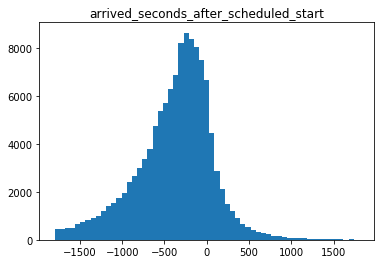

In [26]:
arrival_time_df.dropna().hist(column='arrived_seconds_after_scheduled_start',bins=np.linspace(-1800,1800,60),grid=False)


In [27]:
# arrives 8.5 minutes early on average
arrival_time_df[['arrived_seconds_after_scheduled_start']].dropna().mean()/60

arrived_seconds_after_scheduled_start   -8.456539
dtype: float64

In [28]:
# most often arrives 4.5 minutes early on average
arrival_time_df[['arrived_seconds_after_scheduled_start']].dropna().mode()/60

,arrived_seconds_after_scheduled_start
0,-4.45


In [29]:
# show rows and label to verify logic
# arrived_late_df[arrived_late_df['label']].head # version where label is TRUE
arrival_time_df.head

<bound method NDFrame.head of             id scheduled_starts_at_pdt origin_arrived_at_pdt  \
0       367322     2017-03-09 08:00:00                   NaT   
1       492666     2017-09-11 10:00:00                   NaT   
2       527985     2017-09-27 15:07:00                   NaT   
3       415557     2017-05-22 21:16:00                   NaT   
4       317210     2017-01-22 10:00:00                   NaT   
5       338150     2017-02-14 16:00:00   2017-02-14 15:51:43   
6       310958     2017-01-24 16:20:00   2017-01-24 16:20:05   
7       338135     2017-02-08 16:00:00   2017-02-08 15:54:47   
8       324615     2017-01-26 16:30:00   2017-01-26 16:25:04   
9       247127     2017-01-23 14:45:00   2017-01-23 14:42:14   
10      306833     2017-01-11 14:25:00   2017-01-11 14:20:23   
11      436184     2017-06-26 13:30:00   2017-06-26 13:15:40   
12      473473     2017-08-21 14:30:00   2017-08-21 14:10:25   
13      354050     2017-02-27 15:00:00   2017-02-27 14:48:47   
14      41

In [30]:
# features look ok, contain some NaNs
df[feature_columns_to_use].head

<bound method NDFrame.head of         is_affiliate_int  driver_signup_before_trip_claimed_secs  \
0                      0                              21333623.0   
1                      0                              36537454.0   
2                      0                              38875408.0   
3                      0                              27813756.0   
4                      0                              17088945.0   
5                      0                              18850635.0   
6                      0                              16965945.0   
7                      0                              18686136.0   
8                      0                              17717081.0   
9                      0                              16879496.0   
10                     0                              16402111.0   
11                     0                              30774059.0   
12                     0                              35573582.0   
13                

In [31]:
# hmmm too many NaNs
df[feature_columns_to_use].dropna().shape

(64, 86)

In [32]:
# replace NaNs with 0s, although another solution for missing latlons is probably better
df[feature_columns_to_use].fillna(0).shape

(217348, 86)

In [33]:
# eliminate rows where on-time arrival cannot be computed (canceled before arrival, possibly filled).
df.loc[df['origin_arrived_at_pdt'].notnull()].shape

(125675, 132)

In [34]:
# how many observations of each final state do we have left where on-time arrival can be labeled
df.loc[df['origin_arrived_at_pdt'].notnull()].groupby(['trip_state']).size()

trip_state
canceled      1529
complete    124146
dtype: int64

In [35]:
# how many are filled; all should be but 1 wierd trip arrived with no driver! 
# chaotic race condition when scheduled start time approaching, cancel by organizer, removing driver, and driver arriving 
# It will be filled with 0 which is ok.
df.loc[df['origin_arrived_at_pdt'].notnull()].groupby(['trip_state',df.driver_id.notnull()]).size()

trip_state  driver_id
canceled    False             1
            True           1528
complete    True         124146
dtype: int64

In [36]:
# materialize the useful dataset for training and testing
df_X=df.loc[df['origin_arrived_at_pdt'].notnull()][feature_columns_to_use].fillna(0)
df_X.shape

(125675, 86)

In [37]:
# materialize the prediction target (arrived_seconds_after_scheduled_start)
y=(df.loc[df['origin_arrived_at_pdt'].notnull()].origin_arrived_at_pdt 
   - df.loc[df['origin_arrived_at_pdt'].notnull()].scheduled_starts_at_pdt).dt.total_seconds()

# describe and convert from scientific notation
y.describe().apply(lambda x: '%.0f' % x)

count      125675
mean         -507
std         22763
min      -7862491
25%          -657
50%          -324
75%           -96
max        204537
dtype: object

In [39]:
# write out features (df_X) and targets (y) into files
fileprefix='./lateness_PREP_V4_'
df_X.to_csv(fileprefix+'X.csv', sep='\t')


In [40]:
y.to_csv(path=fileprefix+'y.csv', sep='\t')

In [41]:
y.shape

(125675,)

In [42]:
y.head()

5   -497.0
6      5.0
7   -313.0
8   -296.0
9   -166.0
dtype: float64